In [1]:
import pickle
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
sys.path.append('../')
from axia import report
from axia import SBGSurvival

from importlib import reload

# Load Subscription Data

In [50]:
# with open("./jobber_working_data.pkl", "rb") as f:
with open("./jobber_working_data-20180101_split.pkl", "rb") as f:
    data = pickle.load(f)

In [51]:
data.dtr.head()

,start_date,end_date,age,alive,subscription_initial,subscription_last,subscription_current,frequency,country,industry
account_id,,,,,,,,,,
2,2011-04-01,NaT,81,1,65.0,128.0,128.0,monthly,canada,painting
34,2012-04-01,NaT,69,1,47.0,47.0,47.0,monthly,canada,arborist_/_tree_care
87,2014-04-01,2015-02-01,10,0,39.0,39.0,0.0,monthly,united_states,lawn_care_&_lawn_maintenance
109,2011-05-01,NaT,80,1,38.0,47.0,47.0,monthly,canada,painting
137,2016-03-01,2016-08-01,5,0,68.0,68.0,0.0,monthly,united_states,mechanical_service


# Retention

In [52]:
def group_colour_map(group_labels, cmap_name="viridis", overwrite_map=None):
    """Slice a color map by group and assing same color to group samples.

    params:
        group_labels (list, array, series): An iterable with a label for
            each sample in the dataset.
        cmap_name (str): Name of the color map to be used
        overwrite_map (RGBA tuple): rgba tuple to use for a particular
            label, overwriting the cmap slice.
    """
    from matplotlib.cm import get_cmap
    from pandas import unique
    cmap = get_cmap(cmap_name)

    if overwrite_map is None:
        overwrite_map = {}

    unique_labels = sorted(unique(group_labels))
    n_labels = len(unique_labels)
    label_index_map = dict(zip(unique_labels, range(n_labels)))

    def rgba(l):
        try:
            return overwrite_map[l]
        except KeyError:
            return cmap(label_index_map[l] / n_labels)

    return [rgba(l) for l in group_labels]


def date_to_quarter(df, col="start_date", n_months=3):
    def _date_to_quarter(dt):
        quarter = ((dt.month - 1) // n_months) + 1
        return dt.replace(month=quarter * n_months, day=1)
    df = df.copy()
    df.insert(0, "start_quarter", df[col].apply(_date_to_quarter))
    return df

In [53]:
retention_actual = (
    data.cdva
    .pipe(date_to_quarter, n_months=3)
    .groupby(["start_quarter", "age"])
    .agg({"alive": "mean"})
)

In [54]:
adf = retention_actual.unstack("age").loc["2014-01-01":].T.reset_index(0, drop=True)

# SBG

In [55]:
N_MONTHS = 18

In [56]:
dtr = data.dtr.join(data.features()).dropna(subset=['month_one_retention_trend_s3', 'month_one_retention_trend_s12'])
dva = data.dva.join(data.features())
sample_weight = np.exp(-(((dtr["start_date"].max() - dtr["start_date"]).dt.days / 30 + 1) ** 0.25) + 1)

In [57]:
features = [
    "country",
    "industry",
    "frequency",
    "month_one_retention_trend_s3",
    "month_one_retention_trend_s12",
]

sbg = SBGSurvival(
    age='age',
    alive='alive',
    features=features,
    gamma=1e-3,
    verbose=False
)

In [58]:
%%time
sbg.fit(
    df=dtr,
#     sample_weight=sample_weight,
)

CPU times: user 1min 36s, sys: 163 ms, total: 1min 36s
Wall time: 1min 36s


In [92]:
predicted_retention = sbg.predict_survival(dva, n_periods=N_MONTHS + 1)

In [60]:
retention_sbg = (
    predicted_retention
    .join(data.dva[["start_date"]])
    .reset_index("age")
    .pipe(date_to_quarter, n_months=3)
    .groupby(["start_quarter", "age"])
    .agg({"probability": "mean"})
)

sdf = retention_sbg.unstack("age").loc["2014-01-01":].T.reset_index(0, drop=True)

In [97]:
dva[["age"]]

,age
account_id,
2,81
34,69
87,10
109,80
137,5
184,68
190,75
243,36
259,1


In [107]:
def _new_age(df):
    d = df.copy()
    d["age"] = d["period"] + d["age"]
    return d

predicted_retention.join(dva["age"]).rename(columns={"age": "oage"}).reset_index("age").rename(columns={"age": "period", "oage": "age"}).pipe(_new_age).set_index(["age", "period"], append=True)

probability
account_id age period             
2          81  0               NaN
           82  1               NaN
           83  2               NaN
           84  3               NaN
           85  4               NaN
           86  5               NaN
           87  6               NaN
           88  7               NaN
           89  8               NaN
           90  9               NaN
           91  10              NaN
           92  11              NaN
           93  12              NaN
           94  13              NaN
           95  14              NaN
           96  15              NaN
           97  16              NaN
           98  17              NaN
           99  18              NaN
34         69  0          1.000000
           70  1          0.995060
           71  2          0.990195
           72  3          0.985405
           73  4          0.980686
           74  5          0.976037
           75  6          0.971457
           76  7          0.966944
           77  8          0.962496
           78  9          0.958111
           79  10         0.953788
...                            ...
138647     9   8          0.712113
           10  9          0.692356
           11  10         0.674339
           12  11         0.657816
           13  12         0.642587
           14  13         0.628489
           15  14         0.615385
           16  15         0.603162
           17  16         0.591724
           18  17         0.580988
           19  18         0.570883
138650     1   0          1.000000
           2   1          0.928757
           3   2          0.874478
           4   3          0.831157
           5   4          0.795424
           6   5          0.765220
           7   6          0.739200
           8   7          0.716444
           9   8          0.696296
           10  9          0.678273
           11  10         0.662010
           12  11         0.647228
           13  12         0.633703
           14  13         0.621261
           15  14         0.609758
           16  15         0.599075
           17  16         0.589117
           18  17         0.579800
           19  18         0.571055

[326211 rows x 1 columns]

In [85]:
dva.head()

,start_date,end_date,age,alive,subscription_initial,subscription_last,subscription_current,frequency,country,industry,month_one_retention_trend_s3,month_one_retention_trend_s12
account_id,,,,,,,,,,,,
2,2011-04-01,NaT,81,1,65.0,128.0,128.0,monthly,canada,painting,NaN,NaN
34,2012-04-01,NaT,69,1,47.0,47.0,47.0,monthly,canada,arborist_/_tree_care,1.000000,1.000000
87,2014-04-01,2015-02-01,10,0,39.0,39.0,0.0,monthly,united_states,lawn_care_&_lawn_maintenance,0.940279,0.980724
109,2011-05-01,NaT,80,1,38.0,47.0,47.0,monthly,canada,painting,NaN,NaN
137,2016-03-01,2016-08-01,5,0,68.0,68.0,0.0,monthly,united_states,mechanical_service,0.937191,0.951022


In [86]:
predicted_retention.loc[34]

,probability
age,
0,1.000000
1,0.995060
2,0.990195
3,0.985405
4,0.980686
5,0.976037
6,0.971457
7,0.966944
8,0.962496


In [88]:
predicted_retention.loc[138650]

,probability
age,
0,1.000000
1,0.928757
2,0.874478
3,0.831157
4,0.795424
5,0.765220
6,0.739200
7,0.716444
8,0.696296


# Traditional

In [64]:
def _churn_rate(df):
    df["churn_rate"] = (df["is_cancelation_month"] / df["alive"]).fillna(0)
    df["avg_churn_6m"] = df['churn_rate'].rolling(window=6).mean().fillna(0)
    return df[["churn_rate", "avg_churn_6m"]]

def _cross_product(df, other):
    df = df.copy().reset_index()
    df['dummy'] = 1
    df = df.merge(
        other.reset_index(),
        on="dummy",
        how="outer"
    )
    df = df.set_index(["start_quarter", "age"])
    df = df.drop("dummy", axis=1)
    return df.sort_index()

def _retention_rate(df):
    def _retention_by_age(row, col="churn_rate"):
        return (1 - row[col]) ** row["age"]
    df = df.reset_index("age")
    df["churn"] = df.apply(
        lambda row: _retention_by_age(row, "avg_churn_6m"), axis=1)
    
    df = df.set_index('age', append=True)
    return df[["churn"]]
    
    

_age_df = pd.DataFrame(
    data=np.ones(N_MONTHS).astype(int),
    index=pd.Series(range(N_MONTHS), name="age"),
    columns=["dummy"],
)

retention_traditional = (
    data.cdf
    .reset_index("end_of_month")
    .pipe(date_to_quarter, col="end_of_month", n_months=3)
    .groupby("start_quarter")
    .agg({
        'alive': "sum",
        "is_starting_month": 'sum',
        'is_cancelation_month': 'sum',
    })
    .pipe(_churn_rate)
    .pipe(_cross_product, other=_age_df)
    .pipe(_retention_rate)
)


tdf = retention_traditional.unstack("age").loc["2014-01-01":].T.reset_index(0, drop=True)
retention_traditional.tail(10)

churn
start_quarter age          
2019-03-01    8    0.830601
              9    0.811552
              10   0.792941
              11   0.774756
              12   0.756988
              13   0.739627
              14   0.722665
              15   0.706091
              16   0.689898
              17   0.674076

# Global curve

In [68]:
# fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# adf.mean(axis=1).plot(ax=ax, style=".-")
# sdf.mean(axis=1).plot(ax=ax)
# tdf.mean(axis=1).plot(ax=ax)
# ax.grid(True)
# ax.set_xbound((0, N_MONTHS))

# Together

In [69]:
from sklearn import metrics

In [71]:
retention_all

alive  probability     churn
start_quarter age                                 
2015-06-01    31   0.530120          NaN       NaN
              32   0.512821          NaN       NaN
              33   0.508861          NaN       NaN
              34   0.506329          NaN       NaN
              35   0.503797          NaN       NaN
              36   0.500000          NaN       NaN
              37   0.493671          NaN       NaN
              38   0.488608          NaN       NaN
              39   0.481013          NaN       NaN
              40   0.473418          NaN       NaN
              41   0.468354          NaN       NaN
              42   0.462025          NaN       NaN
              43   0.456962          NaN       NaN
              44   0.450633          NaN       NaN
              45   0.441774          NaN       NaN
              46   0.438163          NaN       NaN
2015-09-01    28   0.494318          NaN       NaN
              29   0.489362          NaN       NaN
              30   0.490033          NaN       NaN
              31   0.483389          NaN       NaN
              32   0.473422          NaN       NaN
              33   0.473422          NaN       NaN
              34   0.463455          NaN       NaN
              35   0.458472          NaN       NaN
              36   0.450166          NaN       NaN
              37   0.441860          NaN       NaN
              38   0.438538          NaN       NaN
              39   0.433555          NaN       NaN
              40   0.416944          NaN       NaN
              41   0.413621          NaN       NaN
...                     ...          ...       ...
2018-03-01    10   0.693842     0.707683  0.796843
              11   0.678231     0.692632  0.778951
              12   0.652414     0.678644  0.761461
              13   0.641026     0.665583  0.744363
2018-06-01    0    0.987730     1.000000  1.000000
              1    0.929448     0.942504  0.977880
              2    0.876278     0.896558  0.956250
              3    0.820041     0.858478  0.935098
              4    0.784254     0.826084  0.914414
              5    0.747444     0.797982  0.894188
              6    0.720859     0.773226  0.874409
              7    0.699387     0.751148  0.855067
              8    0.680982     0.731256  0.836153
              9    0.679191     0.713180  0.817658
              10   0.669377     0.696635  0.799571
2018-09-01    0    0.972569     1.000000  1.000000
              1    0.892768     0.942351  0.977856
              2    0.814214     0.896576  0.956203
              3    0.769327     0.858809  0.935028
              4    0.738155     0.826791  0.914323
              5    0.706983     0.799086  0.894077
              6    0.674099     0.774726  0.874278
              7    0.643939     0.753031  0.854918
2018-12-01    0    0.981797     1.000000  1.000000
              1    0.908987     0.942512  0.977600
              2    0.846416     0.896783  0.955703
              3    0.782161     0.858990  0.934295
              4    0.724490     0.826896  0.913368
2019-03-01    0    0.983648     1.000000  1.000000
              1    0.914062     0.944971  0.977066

[216 rows x 3 columns]

In [73]:
retention_all = (
    retention_actual
    .join(retention_sbg)
    .join(retention_traditional)
    .loc["2015-06-01":]
)
retention_all.tail(10)

alive  probability     churn
start_quarter age                                 
2018-09-01    5    0.706983     0.799086  0.894077
              6    0.674099     0.774726  0.874278
              7    0.643939     0.753031  0.854918
2018-12-01    0    0.981797     1.000000  1.000000
              1    0.908987     0.942512  0.977600
              2    0.846416     0.896783  0.955703
              3    0.782161     0.858990  0.934295
              4    0.724490     0.826896  0.913368
2019-03-01    0    0.983648     1.000000  1.000000
              1    0.914062     0.944971  0.977066

In [74]:
print(metrics.mean_absolute_error(retention_all['alive'], retention_all['probability']))
print(metrics.mean_absolute_error(retention_all['alive'], retention_all['churn']))

0.0674419798503967
0.08836471795362733


In [75]:
print(metrics.mean_squared_error(retention_all['alive'], retention_all['probability']))
print(metrics.mean_squared_error(retention_all['alive'], retention_all['churn']))

0.006125442695652114
0.009500190278965669


In [269]:
(
    retention_all
    .groupby("start_quarter")
    .apply(lambda df: metrics.mean_absolute_error(df['alive'], df['probability']))
    .to_frame()
    .join(
        retention_all
        .groupby("start_quarter")
        .apply(lambda df: metrics.mean_absolute_error(df['alive'], df['churn']))
        .to_frame()
        , rsuffix='_traditional'
        , lsuffix="_sbg"
    )
)

,0_sbg,0_traditional
start_quarter,,
2015-06-01,0.062775,0.095659
2015-09-01,0.034619,0.048033
2015-12-01,0.031713,0.065013
2016-03-01,0.028555,0.043999
2016-06-01,0.012832,0.043882
2016-09-01,0.028787,0.062898
2016-12-01,0.028539,0.047524
2017-03-01,0.029017,0.060458
2017-06-01,0.021533,0.075583


In [76]:
def plot_cohort_retention_lines(df):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))

    colours = group_colour_map([c.strftime("%Y%m%d") for c in df.columns])
    for col, colour in zip(df.columns, colours):
        df[col].plot(c=colour, ax=ax)
    ax.grid(True)
    ax.set_xbound((0, 60))
    
    return fig, ax

(<Figure size 1440x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1284706d8>)

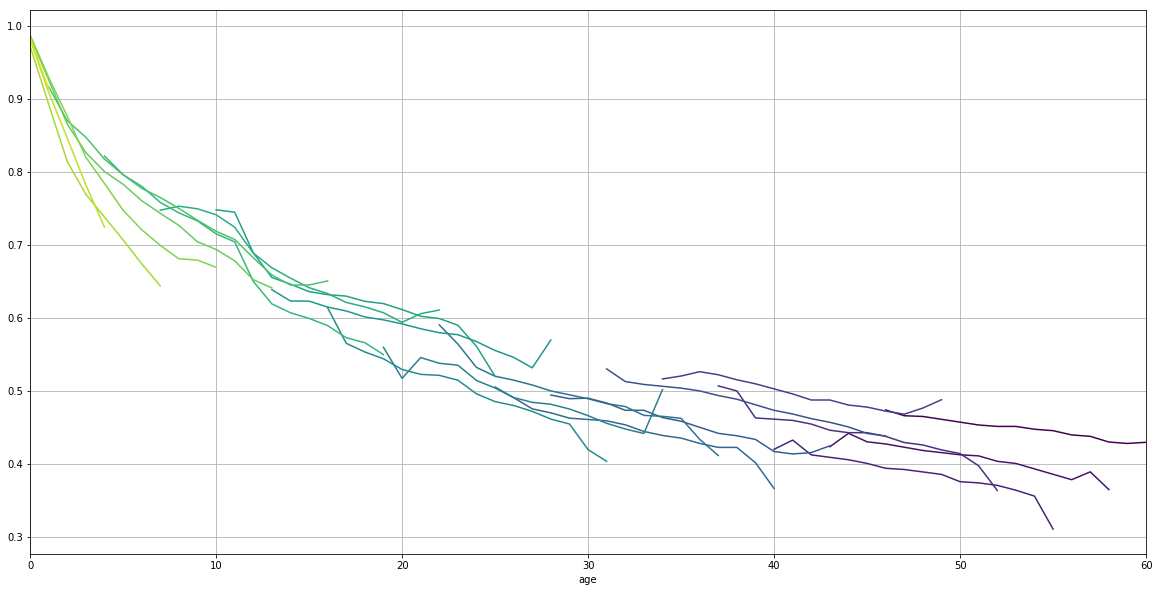

In [77]:
plot_cohort_retention_lines(adf)

In [79]:
sdf

start_quarter,2014-03-01 00:00:00,2014-06-01 00:00:00,2014-09-01 00:00:00,2014-12-01 00:00:00,2015-03-01 00:00:00,2015-06-01 00:00:00,2015-09-01 00:00:00,2015-12-01 00:00:00,2016-03-01 00:00:00,2016-06-01 00:00:00,...,2016-12-01 00:00:00,2017-03-01 00:00:00,2017-06-01 00:00:00,2017-09-01 00:00:00,2017-12-01 00:00:00,2018-03-01 00:00:00,2018-06-01 00:00:00,2018-09-01 00:00:00,2018-12-01 00:00:00,2019-03-01 00:00:00
age,,,,,,,,,,,,,,,,,,,,,
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.983237,0.982370,0.980053,0.980897,0.981096,0.979877,0.980020,0.977577,0.976769,0.976343,...,0.974485,0.974338,0.971709,0.967557,0.959481,0.945242,0.942504,0.942351,0.942512,0.944971
2,0.967315,0.965780,0.961606,0.963372,0.963719,0.961297,0.961573,0.957053,0.955681,0.954853,...,0.951640,0.951162,0.946486,0.939048,0.925206,0.901362,0.896558,0.896576,0.896783,0.900868
3,0.952155,0.950111,0.944440,0.947163,0.947620,0.944028,0.944409,0.938089,0.936304,0.935103,...,0.930850,0.929955,0.923668,0.913569,0.895485,0.864871,0.858478,0.858809,0.858990,0.864198
4,0.937688,0.935266,0.928385,0.932073,0.932610,0.927890,0.928337,0.920435,0.918337,0.916791,...,0.911713,0.910361,0.902800,0.890509,0.869237,0.833716,0.826084,0.826791,0.826896,0.832900
5,0.923857,0.921163,0.913306,0.917948,0.918542,0.912738,0.913212,0.903901,0.901557,0.899693,...,0.893946,0.892118,0.883551,0.869429,0.845727,0.806586,0.797982,0.799086,0.799081,0.805658
6,0.910608,0.907732,0.899089,0.904669,0.905302,0.898458,0.898914,0.888339,0.885796,0.883639,...,0.877341,0.875030,0.865673,0.850006,0.824433,0.782595,0.773226,0.774726,0.774589,0.781581
7,0.897899,0.894913,0.885642,0.892135,0.892793,0.884953,0.885351,0.873630,0.870922,0.868495,...,0.861738,0.858944,0.848974,0.831988,0.804968,0.761115,0.751148,0.753031,0.752745,0.760036
8,0.885688,0.882656,0.872888,0.880267,0.880938,0.872143,0.872442,0.859677,0.856829,0.854152,...,0.847010,0.843737,0.833301,0.815181,0.787040,0.741686,0.731256,0.733504,0.733059,0.740563


(<Figure size 1440x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12789a668>)

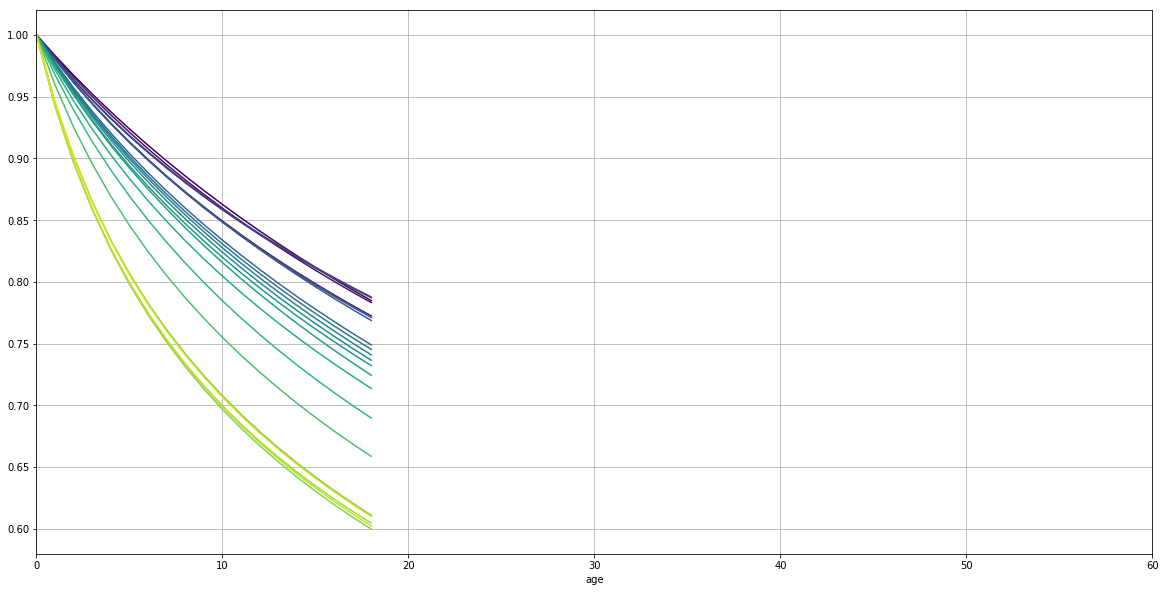

In [78]:
plot_cohort_retention_lines(sdf)

(<Figure size 1440x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1489b6d30>)

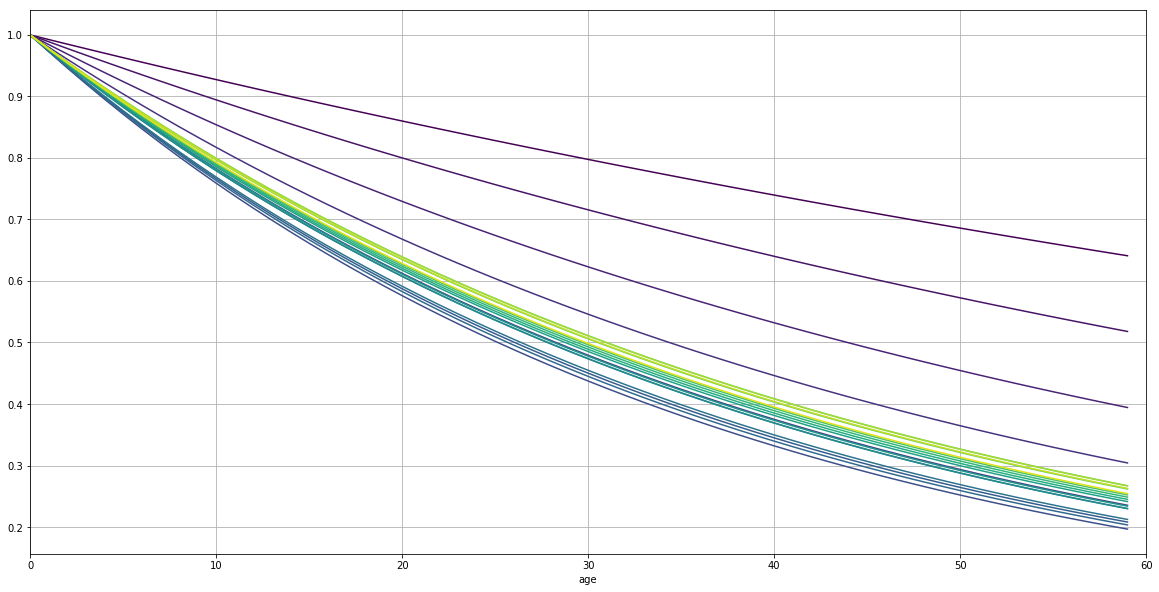

In [279]:
plot_cohort_retention_lines(tdf)

In [ ]:
df.plot()

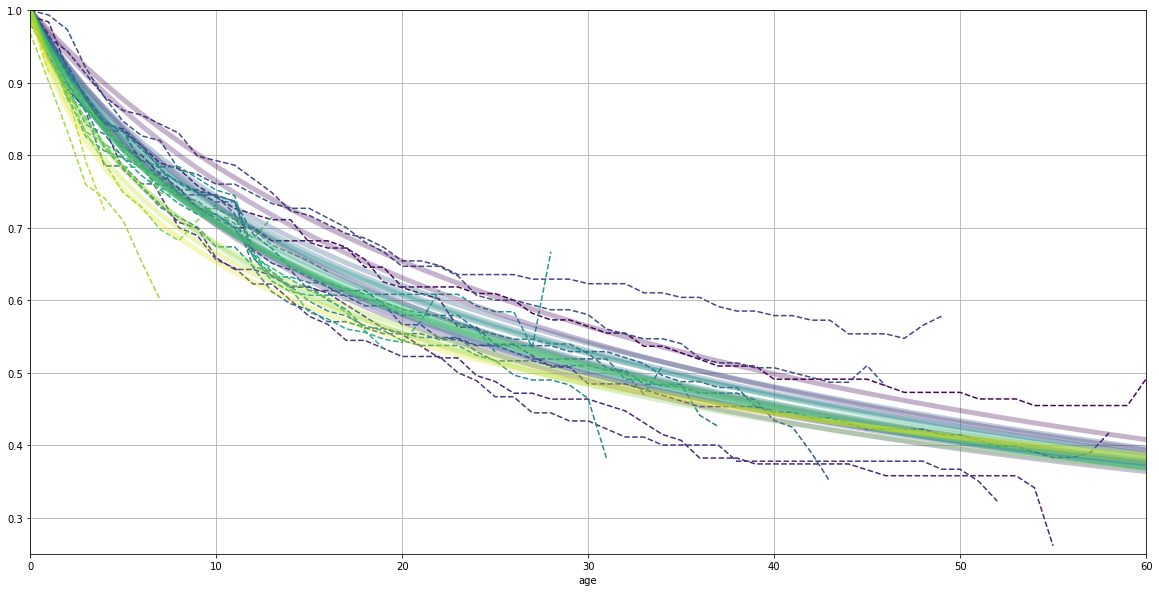

In [294]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

colours = group_colour_map([c.strftime("%Y%m%d") for c in adf.columns])
for col, colour in zip(adf.columns, colours):
    adf[col].plot(style="--", c=colour, ax=ax, alpha=0.99)

colours = group_colour_map([c.strftime("%Y%m%d") for c in sdf.columns])
for col, colour in zip(sdf.columns, colours):
    sdf[col].plot(c=colour, ax=ax, alpha=0.3, linewidth=5)
    
    
ax.grid(True)
ax.set_xbound((0, 60))
ax.set_ybound((0.25, 1))